In [1]:
# ==============================================================================
# 0. LIBRARY IMPORTS
# ==============================================================================
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. CONFIGURATION AND DATA PATHS
# ==============================================================================

# --- Data Paths ---
DATA_DIR = 'data'
MODEL_DIR = 'models'

CSV_FILE_PATH = os.path.join(DATA_DIR, 'training_solutions_rev1.csv')
IMAGES_DIR_PATH = os.path.join(DATA_DIR, 'images_training_rev1')

# --- Model and Training Parameters ---
# Number of images to use. Set to None to use all images found in the CSV.
NUM_IMAGES_TO_USE = None 
# Image dimensions. A larger resolution can help the model recognize finer details
# but requires more computational resources. 224x224 is a common size for ResNet.
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 24 

EPOCHS = 64
LEARNING_RATE = 1e-4
VAL_SPLIT_SIZE = 0.2
TEST_SPLIT_SIZE = 0.2
RANDOM_STATE = 42
# A cap on the class weights to prevent the model from over-emphasizing very small classes.
MAX_CLASS_WEIGHT = 50.0 


# --- Target Classes ---
# The 'Peculiar' class is merged into 'Irregular' to simplify the classification problem.
TARGET_CLASSES = ['Elliptical', 'Spiral', 'Edge-on', 'Irregular'] # 'Peculiar' has been removed

# --- Model Checkpoint Paths ---
MODEL_CHECKPOINT_PATH = os.path.join(MODEL_DIR, 'best_galaxy_classifier_initial_224px_4class_balanced.keras')
FINE_TUNED_MODEL_CHECKPOINT_PATH = os.path.join(MODEL_DIR, 'best_galaxy_classifier_finetuned_224px_4class_balanced.keras')



# --- Galaxy Classification Logic Thresholds ---
# These thresholds are used in the `assign_galaxy_label` function to convert the 
# crowd-sourced probabilities from the Galaxy Zoo CSV file into a single, definitive class label.
# Each threshold represents the minimum probability or ratio for a specific morphological
# question to be considered true for a given galaxy.
GALAXY_TYPE_THRESHOLDS = {
    # Min probability (from Class1.3) that the object is a star or an artifact.
    'artifact_confidence': 0.75,

    # Min probability (from Class1.1) that the galaxy is "smooth," a key feature of Elliptical galaxies.
    'smooth_min_confidence': 0.65,

    # The ratio by which "smooth" probability (Class1.1) must exceed "features/disk" probability (Class1.2)
    # for the galaxy to be classified as Elliptical.
    'smooth_vs_features_ratio': 1.5,

    # Min probability (from Class1.2) that the galaxy has "features/disk," which is the
    # entry point for classifying Spiral, Edge-on, and other non-elliptical galaxies.
    'features_disk_min_confidence': 0.6,

    # Min probability (from Class5.1) that the galaxy is "odd" or peculiar. 
    # These galaxies are mapped to the 'Irregular' class.
    'odd_yes_confidence': 0.6,

    # Min probability (from Class2.1) that a disk galaxy is viewed "edge-on".
    'edge_on_yes_confidence': 0.55,

    # Min probability (from Class2.2) that a disk galaxy is NOT "edge-on" (i.e., it is face-on),
    # which is a prerequisite for checking for spiral arms.
    'edge_on_no_confidence': 0.75,

    # Min probability (from Class4.1) that a face-on disk galaxy has spiral arms.
    'spiral_arms_yes_confidence': 0.50,
}

2025-07-14 22:15:23.421370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752520523.434854    5355 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752520523.438712    5355 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752520523.450392    5355 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752520523.450411    5355 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752520523.450412    5355 computation_placer.cc:177] computation placer alr

In [2]:
# ==============================================================================
# 2. GALAXY TYPE ASSIGNMENT ALGORITHM
# The function is modified to map "Peculiar" galaxies to the "Irregular" class.
# ==============================================================================
def assign_galaxy_label(row, thresholds):
    """
    Assigns a galaxy type label based on classification probabilities.
    'Peculiar' galaxies are merged into the 'Irregular' class.
    """
    prob_artifact = row.get('Class1.3', 0.0)
    prob_smooth = row.get('Class1.1', 0.0)
    prob_features_disk = row.get('Class1.2', 0.0)
    prob_edge_on_yes = row.get('Class2.1', 0.0)
    prob_edge_on_no = row.get('Class2.2', 0.0)
    prob_spiral_yes = row.get('Class4.1', 0.0)
    prob_odd_yes = row.get('Class5.1', 0.0)

    # First, check if the object is likely an artifact.
    if prob_artifact > thresholds['artifact_confidence']:
        return 'Artifact'

    # If the galaxy is considered "odd" (peculiar), classify it as Irregular.
    if prob_odd_yes > thresholds['odd_yes_confidence'] and \
       (prob_smooth > 0.3 or prob_features_disk > 0.3):
        return 'Irregular' # CHANGE: This was 'Peculiar', now mapped to 'Irregular'

    # Classify as Elliptical if it's smooth and lacks features.
    if prob_smooth > thresholds['smooth_min_confidence'] and \
       prob_smooth > prob_features_disk * thresholds['smooth_vs_features_ratio'] and \
       prob_smooth > prob_artifact:
        return 'Elliptical'

    # If the galaxy has features/disk, check for other types.
    if prob_features_disk > thresholds['features_disk_min_confidence'] and \
       prob_features_disk > prob_artifact:
        # Check if it's an edge-on galaxy.
        if prob_edge_on_yes > thresholds['edge_on_yes_confidence'] and \
           prob_edge_on_yes > prob_edge_on_no:
            return 'Edge-on'
        # If not edge-on, check for spiral arms.
        if prob_edge_on_no > thresholds['edge_on_no_confidence'] and \
           prob_spiral_yes > thresholds['spiral_arms_yes_confidence']:
            return 'Spiral'
        # If it has features but isn't a clear spiral or edge-on, classify as irregular.
        return 'Irregular'
        
    # Default to Irregular if no other category fits.
    return 'Irregular'

In [3]:
# ==============================================================================
# 3. DATA LOADING AND PREPARATION
# Data is loaded, labels are assigned (merging Peculiar and Irregular),
# images are selected, undersampling is performed, and the data is split.
# ==============================================================================
print("\n--- Data Loading and Initial Preparation ---")
try:
    solutions_df = pd.read_csv(CSV_FILE_PATH)
    print(f"Successfully loaded {CSV_FILE_PATH}, number of records: {len(solutions_df)}")
except FileNotFoundError:
    print(f"CRITICAL ERROR: {CSV_FILE_PATH} not found. Path: {os.path.abspath(CSV_FILE_PATH)}")
    raise SystemExit(f"CRITICAL ERROR: {CSV_FILE_PATH} not found.")

if not os.path.isdir(IMAGES_DIR_PATH):
    print(f"CRITICAL ERROR: Image folder {IMAGES_DIR_PATH} not found. Path: {os.path.abspath(IMAGES_DIR_PATH)}")
    raise SystemExit(f"CRITICAL ERROR: Image folder {IMAGES_DIR_PATH} not found.")
else:
    print(f"Image folder {IMAGES_DIR_PATH} found.")

print("\nAssigning galaxy types (merging Peculiar with Irregular)...")
solutions_df['GalaxyType'] = solutions_df.apply(lambda row: assign_galaxy_label(row, GALAXY_TYPE_THRESHOLDS), axis=1)

solutions_df = solutions_df[solutions_df['GalaxyType'] != 'Artifact']
solutions_df = solutions_df[solutions_df['GalaxyType'].isin(TARGET_CLASSES)]
solutions_df.dropna(subset=['GalaxyID', 'GalaxyType'], inplace=True)

print("\nClass distribution after labeling and filtering (Peculiar merged with Irregular):")
print(solutions_df['GalaxyType'].value_counts()) # This is the distribution BEFORE any sampling

image_data = []
print("\nPreparing image paths and labels...")
processed_ids = set()
for index, row in solutions_df.iterrows():
    galaxy_id = int(row['GalaxyID'])
    if galaxy_id in processed_ids: continue
    image_filename = f"{galaxy_id}.jpg"
    image_path = os.path.join(IMAGES_DIR_PATH, image_filename)
    if os.path.exists(image_path):
        image_data.append({'image_path': image_path, 'label': row['GalaxyType']})
        processed_ids.add(galaxy_id)


image_df = pd.DataFrame(image_data)
if image_df.empty:
    print("CRITICAL ERROR: No images found or they were not associated with labels after initial filtering.")
    raise SystemExit("CRITICAL ERROR: No image data to process.")

print(f"Total images associated with labels (before undersampling/subset): {len(image_df)}")
print("Class distribution of associated images (before undersampling/subset):")
print(image_df['label'].value_counts())


# Check and select a subset BASED ON NUM_IMAGES_TO_USE (IF DESIRED BEFORE BALANCING)
# If NUM_IMAGES_TO_USE is None, this block will be skipped, and all ~61k images will be used for balancing.
# If NUM_IMAGES_TO_USE is set to a specific number (e.g., 20000),
# this subset will be selected first, and THEN it will be balanced.
if NUM_IMAGES_TO_USE is not None and NUM_IMAGES_TO_USE < len(image_df):
    print(f"\nBEFORE BALANCING: Using a subset of {NUM_IMAGES_TO_USE} images.")
    stratify_on_initial_subset = image_df['label'] if len(image_df['label'].unique()) > 1 else None
    image_df, _ = train_test_split(image_df, train_size=NUM_IMAGES_TO_USE, stratify=stratify_on_initial_subset, random_state=RANDOM_STATE)
    print(f"Number of images in subset (before balancing): {len(image_df)}")
    print("Class distribution in subset (before balancing):")
    print(image_df['label'].value_counts())

if image_df.empty: # Check after potential subset selection
    print("CRITICAL ERROR: DataFrame is empty after initial subset selection (before balancing).")
    raise SystemExit("CRITICAL ERROR: No data for balancing.")


print("\n--- Data Balancing (Undersampling) ---")
min_class_size = image_df['label'].value_counts().min()
num_classes_for_balancing = len(image_df['label'].unique())

print(f"Size of the smallest class in the current set: {min_class_size}")
print(f"Target number of images per class after balancing: {min_class_size}")
print(f"Target total number of images after balancing: {min_class_size * num_classes_for_balancing}")

balanced_image_list = []
for galaxy_class in image_df['label'].unique():
    class_subset_df = image_df[image_df['label'] == galaxy_class]
    # Select 'min_class_size' samples from each class
    balanced_class_subset_df = class_subset_df.sample(n=min_class_size, random_state=RANDOM_STATE, replace=False)
    balanced_image_list.append(balanced_class_subset_df)

image_df_balanced = pd.concat(balanced_image_list)
image_df_balanced = image_df_balanced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"\nSize of the balanced set: {len(image_df_balanced)}")
print("Class distribution in the balanced set:")
print(image_df_balanced['label'].value_counts())

image_df = image_df_balanced 
# <<<--- END OF UNDERSAMPLING CODE --- >>>


if image_df.empty:
    print("CRITICAL ERROR: DataFrame is empty after balancing.")
    raise SystemExit("CRITICAL ERROR: No data for training.")

label_encoder = LabelEncoder()
image_df['label_encoded'] = label_encoder.fit_transform(image_df['label'])
NUM_CLASSES = len(label_encoder.classes_)
print(f"\nNumber of unique classes (after merging and balancing): {NUM_CLASSES}")
print(f"Classes: {list(label_encoder.classes_)}")

# Splitting the data into training, validation, and test sets.
# Stratification should now work well as the classes are balanced.
stratify_main_split = image_df['label_encoded']
train_val_df, test_df = train_test_split(
    image_df, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE, stratify=stratify_main_split
)
stratify_train_val_split = train_val_df['label_encoded']
train_df, val_df = train_test_split(
    train_val_df, test_size=VAL_SPLIT_SIZE / (1-TEST_SPLIT_SIZE),
    random_state=RANDOM_STATE, stratify=stratify_train_val_split
)

print(f"\nTraining set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Calculating class weights
class_weights = None
if not train_df.empty and NUM_CLASSES > 1:
    class_labels_encoded_for_weights = train_df['label_encoded']
    unique_classes_in_train = np.unique(class_labels_encoded_for_weights)
    
    if len(unique_classes_in_train) < NUM_CLASSES:
        print(f"Warning: Only {len(unique_classes_in_train)} unique classes found in the training set out of {NUM_CLASSES} possible. "
              "Class weights will be calculated only for the found classes.")
    
    class_weights_values = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=unique_classes_in_train, 
        y=class_labels_encoded_for_weights
    )
    class_weights_values = np.clip(class_weights_values, a_min=None, a_max=MAX_CLASS_WEIGHT)
    class_weights = dict(zip(unique_classes_in_train, class_weights_values))
    print("\nCalculated class weights (for the balanced set):")
    for class_idx, class_name in enumerate(label_encoder.classes_):
        weight = class_weights.get(class_idx, 1.0) 
        print(f"  Class '{class_name}' (encoded {class_idx}): Weight {weight:.2f}")
elif not train_df.empty:
    print("Warning: Only one class in the training data. Class weights are not applied.")
else:
    print("Warning: Training DataFrame is empty. Cannot calculate class weights.")

print("--- Data Preparation Finished (with Undersampling) ---")


--- Data Loading and Initial Preparation ---
Successfully loaded data/training_solutions_rev1.csv, number of records: 61578
Image folder data/images_training_rev1 found.

Assigning galaxy types (merging Peculiar with Irregular)...

Class distribution after labeling and filtering (Peculiar merged with Irregular):
GalaxyType
Irregular     30969
Elliptical    17117
Spiral         9111
Edge-on        4377
Name: count, dtype: int64

Preparing image paths and labels...
Total images associated with labels (before undersampling/subset): 61574
Class distribution of associated images (before undersampling/subset):
label
Irregular     30969
Elliptical    17117
Spiral         9111
Edge-on        4377
Name: count, dtype: int64

--- Data Balancing (Undersampling) ---
Size of the smallest class in the current set: 4377
Target number of images per class after balancing: 4377
Target total number of images after balancing: 17508

Size of the balanced set: 17508
Class distribution in the balanced set:
l

In [4]:
# ==============================================================================
# 4. IMAGE DATA GENERATORS AND PREPROCESSING
# Using 224x224 resolution.
# ==============================================================================
print("\n--- Setting up Image Data Generators (224x224 Resolution) ---")
# Data augmentation for the training set to increase robustness
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=30, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.1, 
    zoom_range=0.1, 
    horizontal_flip=True, 
    vertical_flip=True, 
    fill_mode='nearest'
)
# Only rescaling for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create copies for the generator to avoid potential SettingWithCopyWarning
train_df_gen = train_df.copy()
val_df_gen = val_df.copy()
test_df_gen = test_df.copy()

# Ensure the 'label' column is of string type for categorical class mode
train_df_gen['label'] = train_df_gen['label'].astype(str)
val_df_gen['label'] = val_df_gen['label'].astype(str)
test_df_gen['label'] = test_df_gen['label'].astype(str)

train_generator, validation_generator, test_generator = None, None, None

if not train_df_gen.empty:
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df_gen, 
        x_col='image_path', 
        y_col='label',
        target_size=(IMG_WIDTH, IMG_HEIGHT), 
        batch_size=BATCH_SIZE,
        class_mode='categorical', 
        shuffle=True, 
        seed=RANDOM_STATE
    )
    # Check if the number of classes found by the generator matches the expected number
    if train_generator and len(train_generator.class_indices) != NUM_CLASSES:
        print(f"CRITICAL WARNING: The training generator found {len(train_generator.class_indices)} classes, "
              f"but {NUM_CLASSES} were expected. This could indicate a problem with data splitting or labels.")
        # Updating NUM_CLASSES here could hide an underlying issue, so it's commented out.
        # NUM_CLASSES = len(train_generator.class_indices)
    print(f"Training generator created: {train_generator.samples} samples, {len(train_generator.class_indices) if train_generator else 'N/A'} classes.")
else: 
    print("ERROR: Training dataframe is empty.")

if not val_df_gen.empty:
    validation_generator = val_test_datagen.flow_from_dataframe(
        dataframe=val_df_gen, 
        x_col='image_path', 
        y_col='label',
        target_size=(IMG_WIDTH, IMG_HEIGHT), 
        batch_size=BATCH_SIZE,
        class_mode='categorical', 
        shuffle=False
    )
    print(f"Validation generator created: {validation_generator.samples} samples.")
else: 
    print("Warning: Validation dataframe is empty.")

if not test_df_gen.empty:
    test_generator = val_test_datagen.flow_from_dataframe(
        dataframe=test_df_gen, 
        x_col='image_path', 
        y_col='label',
        target_size=(IMG_WIDTH, IMG_HEIGHT), 
        batch_size=BATCH_SIZE,
        class_mode='categorical', 
        shuffle=False
    )
    print(f"Test generator created: {test_generator.samples} samples.")
else: 
    print("Warning: Test dataframe is empty.")

# A critical check before proceeding to model training
if train_generator is None: 
    print("CRITICAL ERROR: Training generator could not be created. Aborting.")
    raise SystemExit("Training generator creation failed.")

print(f"Class indices from training generator: {train_generator.class_indices if train_generator else 'N/A'}")
print("--- Image Data Generators Ready ---")


# ==============================================================================
# 5. CNN MODEL DEFINITION, COMPILATION, AND OPTIONAL LOADING (INITIAL TRAINING)
# The model will use 224x224 input images.
# ==============================================================================
print("\n--- CNN Model Definition or Loading (Initial Training, 224x224 Input) ---")

def create_galaxy_cnn_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes_model=NUM_CLASSES):
    """
    Creates a CNN model for galaxy classification using ResNet50V2 as a base.
    """
    # Use ResNet50V2 pre-trained on ImageNet, without its top classification layer
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freeze the base model layers
    base_model.trainable = False
    
    # Define the new custom classifier head
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = Dropout(0.4, name="top_dropout_1")(x)
    x = Dense(256, activation='relu', name="top_dense_1")(x)
    x = Dropout(0.3, name="top_dropout_2")(x)
    outputs = Dense(num_classes_model, activation='softmax', name="predictions")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

initial_model = None
if os.path.exists(MODEL_CHECKPOINT_PATH):
    print(f"Loading existing initial model from: {MODEL_CHECKPOINT_PATH}")
    try:
        initial_model = tf.keras.models.load_model(MODEL_CHECKPOINT_PATH)
        # Verify if the loaded model's input shape and class count match the current config
        if initial_model.input_shape[1:3] != (IMG_WIDTH, IMG_HEIGHT):
            print(f"WARNING: Loaded model's input dimensions {initial_model.input_shape[1:3]} "
                  f"do not match current ({IMG_WIDTH}, {IMG_HEIGHT}). Creating a new model.")
            initial_model = create_galaxy_cnn_model(num_classes_model=NUM_CLASSES)
        elif initial_model.output_shape[-1] != NUM_CLASSES:
            print(f"WARNING: Loaded model's output class count {initial_model.output_shape[-1]} "
                  f"does not match current ({NUM_CLASSES}). Creating a new model.")
            initial_model = create_galaxy_cnn_model(num_classes_model=NUM_CLASSES)
        else:
            print("Initial model loaded successfully and matches configuration.")
    except Exception as e:
        print(f"Error loading initial model: {e}. Creating a new initial model.")
        initial_model = create_galaxy_cnn_model(num_classes_model=NUM_CLASSES)
else:
    print(f"Existing initial model not found at {MODEL_CHECKPOINT_PATH}. Creating a new initial model.")
    initial_model = create_galaxy_cnn_model(num_classes_model=NUM_CLASSES)

if initial_model:
    initial_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                          loss='categorical_crossentropy', metrics=['accuracy'])
    initial_model.summary()
else:
    print("CRITICAL ERROR: Initial model could not be created or loaded.")
    raise SystemExit("Initial model initialization failed.")
    
print("--- Initial Model Ready ---")


--- Setting up Image Data Generators (224x224 Resolution) ---
Found 10504 validated image filenames belonging to 4 classes.
Training generator created: 10504 samples, 4 classes.
Found 3502 validated image filenames belonging to 4 classes.
Validation generator created: 3502 samples.
Found 3502 validated image filenames belonging to 4 classes.
Test generator created: 3502 samples.
Class indices from training generator: {'Edge-on': 0, 'Elliptical': 1, 'Irregular': 2, 'Spiral': 3}
--- Image Data Generators Ready ---

--- CNN Model Definition or Loading (Initial Training, 224x224 Input) ---
Loading existing initial model from: models/best_galaxy_classifier_initial_224px_4class_balanced.keras


I0000 00:00:1752520528.724849    5355 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1365 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Initial model loaded successfully and matches configuration.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_1 (Dropout)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dense_1 (Dense)             │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_2 (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,372 (91.90 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

--- Initial Model Ready ---



--- Model Training and Fine-Tuning Section ---

--- Evaluating Initial Training Step ---
Starting initial training for 64 epochs...
Training with: Steps per epoch: 437, Validation steps: 145
Using class weights: Yes
Epoch 1/64


I0000 00:00:1752520534.637873    5474 service.cc:152] XLA service 0x76f6f8002a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752520534.637910    5474 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-07-14 22:15:34.782917: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752520535.713604    5474 cuda_dnn.cc:529] Loaded cuDNN version 90501


  2/437 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.6562 - loss: 0.6372   

I0000 00:00:1752520544.266645    5474 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6828 - loss: 0.7371  

2025-07-14 22:17:11.157875: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1530', 4 bytes spill stores, 4 bytes spill loads

2025-07-14 22:17:11.493719: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1530', 220 bytes spill stores, 220 bytes spill loads

2025-07-14 22:17:11.742384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1530', 8 bytes spill stores, 8 bytes spill loads

2025-07-14 22:17:11.757808: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1530', 4384 bytes spill stores, 4228 bytes spill loads

2025-07-14 22:17:12.102946: I external


Epoch 1: val_accuracy improved from -inf to 0.72385, saving model to models/best_galaxy_classifier_initial_224px_4class_balanced.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 114s 232ms/step - accuracy: 0.6828 - loss: 0.7371 - val_accuracy: 0.7239 - val_loss: 0.6426 - learning_rate: 1.0000e-04
Epoch 2/64
  1/437 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - accuracy: 0.7917 - loss: 0.5654
Epoch 2: val_accuracy improved from 0.72385 to 0.72586, saving model to models/best_galaxy_classifier_initial_224px_4class_balanced.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.7917 - loss: 0.5654 - val_accuracy: 0.7259 - val_loss: 0.6422 - learning_rate: 1.0000e-04
Epoch 3/64
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6858 - loss: 0.7273  
Epoch 3: val_accuracy improved from 0.72586 to 0.73017, saving model to models/best_galaxy_classifier_initial_224px_4class_balanced.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 91s 207ms/step - accuracy: 0.6858 - loss: 0.7273 - val_accuracy: 0.7302 - val_loss: 0

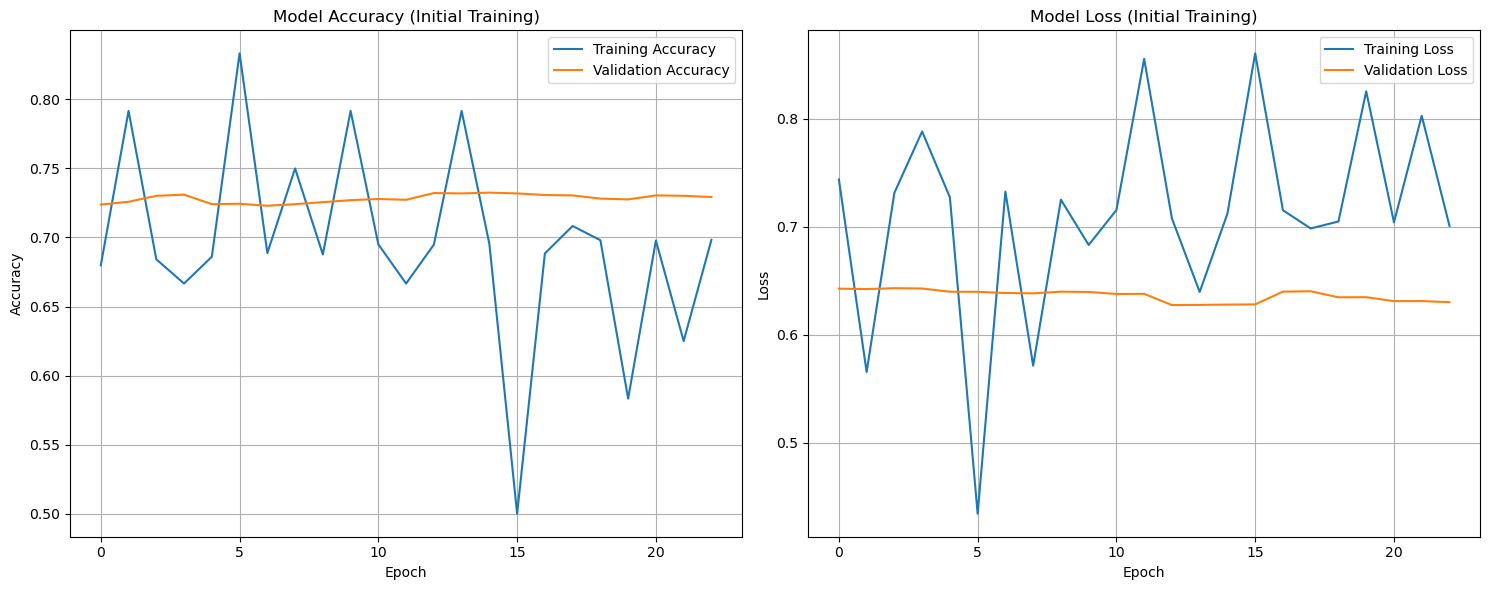

--- Initial Model Training Finished (or Skipped) ---

--- Evaluating Fine-Tuning Step ---
Loading model from models/best_galaxy_classifier_initial_224px_4class_balanced.keras for fine-tuning.
Model loaded successfully for fine-tuning.
Unfreezing layers from index 133 for fine-tuning.
Model recompiled for fine-tuning.
Starting fine-tuning for 16 epochs.
Epoch 1/16
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6229 - loss: 0.8777  
Epoch 1: val_accuracy improved from -inf to 0.74138, saving model to models/best_galaxy_classifier_finetuned_224px_4class_balanced.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 131s 255ms/step - accuracy: 0.6230 - loss: 0.8775 - val_accuracy: 0.7414 - val_loss: 0.6004 - learning_rate: 1.0000e-05
Epoch 2/16
  1/437 ━━━━━━━━━━━━━━━━━━━━ 1:16 176ms/step - accuracy: 0.5417 - loss: 0.8078
Epoch 2: val_accuracy did not improve from 0.74138
437/437 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.5417 - loss: 0.8078 - val_accuracy: 0.7411 - val_loss: 0.6002 - learnin

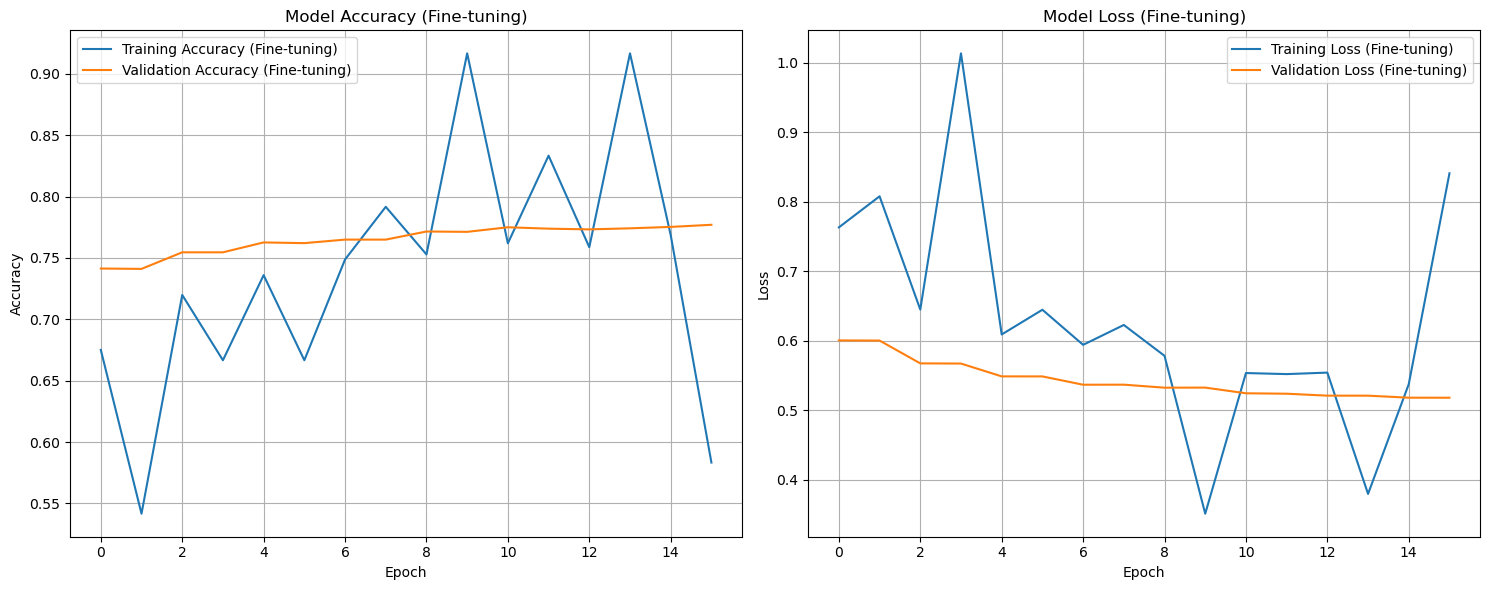

--- Model Fine-tuning Finished (or Skipped) ---


In [5]:
# ==============================================================================
# 6. MODEL TRAINING & 7. FINE-TUNING
# ==============================================================================

print("\n--- Model Training and Fine-Tuning Section ---")

# CORRECTED: Define steps_per_epoch and validation_steps here so they are
# available for both initial training and fine-tuning, regardless of epoch counts.
steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE) if train_generator else 0
validation_steps = max(1, validation_generator.samples // BATCH_SIZE) if validation_generator else 0


# --- Block 6: Initial Training (Head Only) ---
print("\n--- Evaluating Initial Training Step ---")

# Only proceed with training if the number of epochs is greater than 0.
if EPOCHS > 0:
    # Checkpoint to save the best model based on validation accuracy
    checkpoint_initial = ModelCheckpoint(
        MODEL_CHECKPOINT_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
    early_stopping_initial = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )
    reduce_lr_initial = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    history_initial = None
    if initial_model and train_generator and validation_generator and steps_per_epoch > 0 and validation_steps > 0:
        print(f"Starting initial training for {EPOCHS} epochs...")
        print(f"Training with: Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")
        print(f"Using class weights: {'Yes' if class_weights else 'No'}")
        history_initial = initial_model.fit(
            train_generator,
            epochs=EPOCHS,
            initial_epoch=0,
            validation_data=validation_generator,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            callbacks=[checkpoint_initial, early_stopping_initial, reduce_lr_initial],
            class_weight=class_weights if class_weights else None,
            verbose=1
        )
        if history_initial and history_initial.history:
            print("\nPlotting initial training history...")
            plt.figure(figsize=(15, 6))
            # Accuracy Plot
            plt.subplot(1, 2, 1)
            plt.plot(history_initial.history['accuracy'], label='Training Accuracy')
            plt.plot(history_initial.history['val_accuracy'], label='Validation Accuracy')
            plt.title('Model Accuracy (Initial Training)')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)
            # Loss Plot
            plt.subplot(1, 2, 2)
            plt.plot(history_initial.history['loss'], label='Training Loss')
            plt.plot(history_initial.history['val_loss'], label='Validation Loss')
            plt.title('Model Loss (Initial Training)')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        print("ERROR: Training conditions not met. Cannot start initial training.")
else:
    print("Skipping initial model training because EPOCHS is set to 0.")

print("--- Initial Model Training Finished (or Skipped) ---")


# --- Block 7: Model Fine-Tuning ---
print("\n--- Evaluating Fine-Tuning Step ---")
FINE_TUNE_EPOCHS = 16
FINE_TUNE_LEARNING_RATE = LEARNING_RATE / 10
UNFREEZE_PERCENT = 0.3

# Only proceed with fine-tuning if the number of epochs is greater than 0.
if FINE_TUNE_EPOCHS > 0:
    fine_tune_model = None
    if os.path.exists(MODEL_CHECKPOINT_PATH):
        print(f"Loading model from {MODEL_CHECKPOINT_PATH} for fine-tuning.")
        try:
            fine_tune_model = tf.keras.models.load_model(MODEL_CHECKPOINT_PATH)
            if fine_tune_model.input_shape[1:3] != (IMG_WIDTH, IMG_HEIGHT) or \
               fine_tune_model.output_shape[-1] != NUM_CLASSES:
                print("WARNING: Loaded model's configuration does not match. Fine-tuning aborted.")
                fine_tune_model = None
            else:
                 print("Model loaded successfully for fine-tuning.")
        except Exception as e:
            print(f"Error loading model for fine-tuning: {e}")
            fine_tune_model = None
    else:
        print(f"ERROR: Model checkpoint {MODEL_CHECKPOINT_PATH} not found. Cannot fine-tune.")

    if fine_tune_model:
        if len(fine_tune_model.layers) > 1 and isinstance(fine_tune_model.layers[1], tf.keras.Model):
            base_model_to_fine_tune = fine_tune_model.layers[1]
            base_model_to_fine_tune.trainable = True
            num_base_layers = len(base_model_to_fine_tune.layers)
            fine_tune_from_layer_index = int(num_base_layers * (1 - UNFREEZE_PERCENT))
            print(f"Unfreezing layers from index {fine_tune_from_layer_index} for fine-tuning.")

            for layer_idx, layer in enumerate(base_model_to_fine_tune.layers):
                layer.trainable = (layer_idx >= fine_tune_from_layer_index)

            fine_tune_model.compile(optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
                                      loss='categorical_crossentropy', metrics=['accuracy'])
            print("Model recompiled for fine-tuning.")

            ft_checkpoint = ModelCheckpoint(FINE_TUNED_MODEL_CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
            ft_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
            ft_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

            print(f"Starting fine-tuning for {FINE_TUNE_EPOCHS} epochs.")
            history_fine_tune = fine_tune_model.fit(
                train_generator,
                epochs=FINE_TUNE_EPOCHS,
                initial_epoch=0,
                validation_data=validation_generator,
                steps_per_epoch=steps_per_epoch,
                validation_steps=validation_steps,
                callbacks=[ft_checkpoint, ft_early_stopping, ft_reduce_lr],
                class_weight=class_weights if class_weights else None
            )
            if history_fine_tune and history_fine_tune.history:
                print("\nPlotting fine-tuning history...")
                plt.figure(figsize=(15, 6))
                # Accuracy Plot
                plt.subplot(1, 2, 1)
                plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy (Fine-tuning)')
                plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
                plt.title('Model Accuracy (Fine-tuning)')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.grid(True)
                # Loss Plot
                plt.subplot(1, 2, 2)
                plt.plot(history_fine_tune.history['loss'], label='Training Loss (Fine-tuning)')
                plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss (Fine-tuning)')
                plt.title('Model Loss (Fine-tuning)')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
        else:
            print("ERROR: Could not identify the base model layer for fine-tuning.")
    else:
         print("Could not proceed with fine-tuning because a valid model was not loaded.")
else:
    print("Skipping model fine-tuning because FINE_TUNE_EPOCHS is set to 0.")

print("--- Model Fine-tuning Finished (or Skipped) ---")


--- Model Evaluation on the Test Set ---
Attempting to load the FINE-TUNED model from: models/best_galaxy_classifier_finetuned_224px_4class_balanced.keras
Model (Fine-tuned) loaded successfully from models/best_galaxy_classifier_finetuned_224px_4class_balanced.keras for evaluation.
Evaluating the Fine-tuned model with test_steps: 146
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7681 - loss: 0.5246 

2025-07-14 22:52:46.855109: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1530', 220 bytes spill stores, 220 bytes spill loads

2025-07-14 22:52:46.900411: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1530', 4 bytes spill stores, 4 bytes spill loads

2025-07-14 22:52:47.079935: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1530', 8 bytes spill stores, 8 bytes spill loads

2025-07-14 22:52:47.346715: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1530', 4384 bytes spill stores, 4228 bytes spill loads

2025-07-14 22:52:47.732564: I external

146/146 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - accuracy: 0.7681 - loss: 0.5247

Test Loss (Fine-tuned model): 0.5299
Test Accuracy (Fine-tuned model): 0.7650

Generating classification report and confusion matrix...
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step

Classification Report (Fine-tuned model):
              precision    recall  f1-score   support

     Edge-on       0.88      0.95      0.92       876
  Elliptical       0.73      0.81      0.77       875
   Irregular       0.58      0.43      0.49       876
      Spiral       0.82      0.87      0.84       875

    accuracy                           0.76      3502
   macro avg       0.75      0.77      0.75      3502
weighted avg       0.75      0.76      0.75      3502



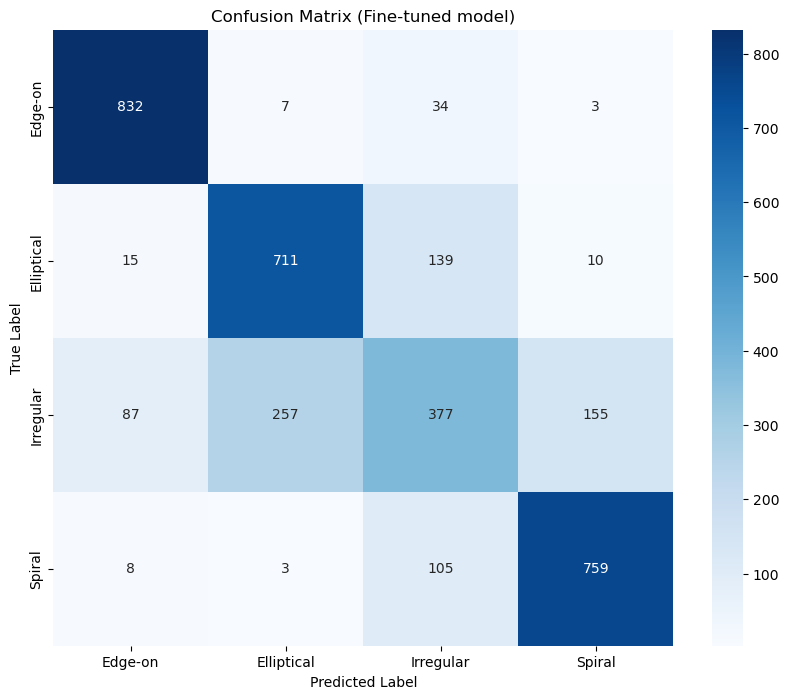


--- Galaxy Classification Task Finished ---


In [6]:
# ==============================================================================
# 8. MODEL EVALUATION ON THE TEST SET
# The best model (fine-tuned or initial) is evaluated on the test set.
# ==============================================================================
print("\n--- Model Evaluation on the Test Set ---")
from sklearn.metrics import classification_report, confusion_matrix

best_model_to_evaluate = None
evaluation_model_path = ""
# Variable to indicate which model is being evaluated
model_type_for_evaluation = "Not set" 

# Prioritize loading the fine-tuned model if it exists
if os.path.exists(FINE_TUNED_MODEL_CHECKPOINT_PATH):
    print(f"Attempting to load the FINE-TUNED model from: {FINE_TUNED_MODEL_CHECKPOINT_PATH}")
    evaluation_model_path = FINE_TUNED_MODEL_CHECKPOINT_PATH
    model_type_for_evaluation = "Fine-tuned"
# Fallback to the initial model if the fine-tuned one is not found
elif os.path.exists(MODEL_CHECKPOINT_PATH):
    print(f"Fine-tuned model not found. Attempting to load the INITIAL model from: {MODEL_CHECKPOINT_PATH}")
    evaluation_model_path = MODEL_CHECKPOINT_PATH
    model_type_for_evaluation = "Initial"
else:
    print("ERROR: Neither the initial nor the fine-tuned model checkpoint was found. Cannot evaluate.")

if evaluation_model_path:
    try:
        best_model_to_evaluate = tf.keras.models.load_model(evaluation_model_path)
        print(f"Model ({model_type_for_evaluation}) loaded successfully from {evaluation_model_path} for evaluation.")
        # Additional check to ensure the loaded model's configuration matches the current one
        if best_model_to_evaluate.output_shape[-1] != NUM_CLASSES:
            print(f"CRITICAL WARNING: Loaded model's ({model_type_for_evaluation}) class count ({best_model_to_evaluate.output_shape[-1]}) "
                  f"does not match the current NUM_CLASSES ({NUM_CLASSES}). Evaluation results may be misleading.")
    except Exception as e:
        print(f"Error loading model ({model_type_for_evaluation}) from {evaluation_model_path}: {e}")
        best_model_to_evaluate = None # Important to set to None on failure

if test_generator and best_model_to_evaluate:
    test_steps = max(1, (test_generator.samples + BATCH_SIZE - 1) // BATCH_SIZE)
    print(f"Evaluating the {model_type_for_evaluation} model with test_steps: {test_steps}")
    test_loss, test_accuracy = best_model_to_evaluate.evaluate(test_generator, steps=test_steps, verbose=1)
    print(f"\nTest Loss ({model_type_for_evaluation} model): {test_loss:.4f}")
    print(f"Test Accuracy ({model_type_for_evaluation} model): {test_accuracy:.4f}")

    print("\nGenerating classification report and confusion matrix...")
    predictions = best_model_to_evaluate.predict(test_generator, steps=test_steps, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    num_samples_for_report = min(len(true_classes), len(predicted_classes))

    report = classification_report(
        true_classes[:num_samples_for_report], predicted_classes[:num_samples_for_report],
        target_names=class_labels, zero_division=0
    )
    print(f"\nClassification Report ({model_type_for_evaluation} model):")
    print(report)

    cm = confusion_matrix(true_classes[:num_samples_for_report], predicted_classes[:num_samples_for_report])
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix ({model_type_for_evaluation} model)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
elif not best_model_to_evaluate:
    print("ERROR: Model is not available for evaluation.")
else:
    print("ERROR: Test generator is not available. Skipping evaluation.")
print("\n--- Galaxy Classification Task Finished ---")


--- Displaying Example Predictions (Predicting one image at a time) ---
Loading Fine-tuned model for prediction display from: models/best_galaxy_classifier_finetuned_224px_4class_balanced.keras
Model loaded successfully.
Fetching and predicting images one by one (up to 16)...
  Processed 5/16 images...
  Processed 10/16 images...
  Processed 15/16 images...

Plotting 16 images with Fine-tuned model predictions...


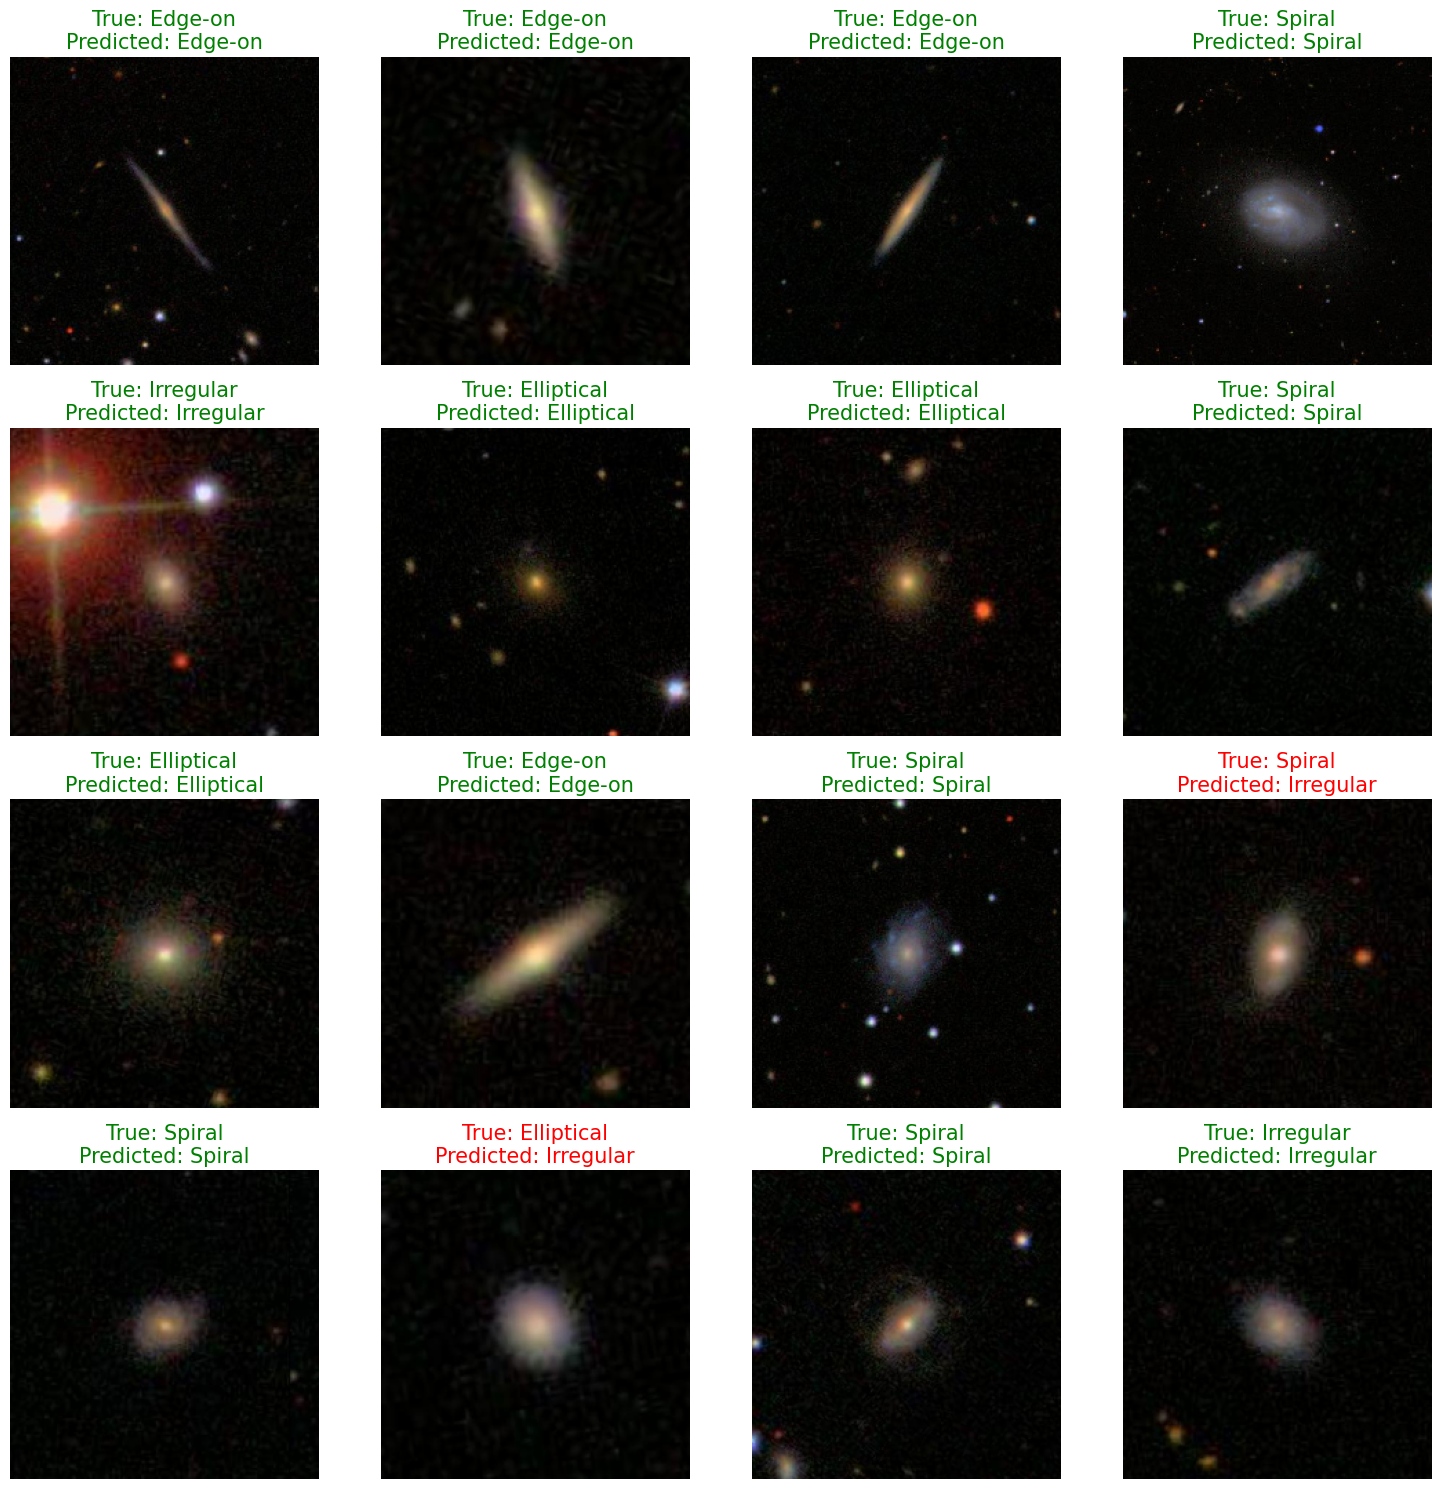


--- Prediction Display Finished ---


In [7]:
# ==============================================================================
# 9. DISPLAYING EXAMPLE PREDICTIONS
# Several images are displayed with their true and predicted labels.
# Modified to predict one image at a time to avoid memory errors.
# ==============================================================================
print("\n--- Displaying Example Predictions (Predicting one image at a time) ---")

# --- Display Configuration ---
NUM_IMAGES_TO_DISPLAY_VISUALIZATION = 16 # How many images to display in total
FIG_SIZE_WIDTH = 15
FIG_SIZE_HEIGHT = 15

# --- Load the best model (fine-tuned if available, otherwise initial) ---
display_model_path_final = ""
model_type_for_display = "Not Set"
if os.path.exists(FINE_TUNED_MODEL_CHECKPOINT_PATH):
    display_model_path_final = FINE_TUNED_MODEL_CHECKPOINT_PATH
    model_type_for_display = "Fine-tuned"
elif os.path.exists(MODEL_CHECKPOINT_PATH):
    display_model_path_final = MODEL_CHECKPOINT_PATH
    model_type_for_display = "Initial"

evaluation_model_for_display = None
if display_model_path_final:
    print(f"Loading {model_type_for_display} model for prediction display from: {display_model_path_final}")
    try:
        evaluation_model_for_display = tf.keras.models.load_model(display_model_path_final)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model: {e}. Cannot display predictions.")
else:
    print("Model checkpoint not found. Cannot display predictions.")

if evaluation_model_for_display and 'test_generator' in locals() and test_generator is not None:
    test_generator.reset() # Important to reset the generator
    
    # Create lists to store images, true labels, and predicted labels
    images_to_plot = []
    true_indices_to_plot = []
    predicted_indices_to_plot = []
    
    print(f"Fetching and predicting images one by one (up to {NUM_IMAGES_TO_DISPLAY_VISUALIZATION})...")
    
    try:
        for i in range(NUM_IMAGES_TO_DISPLAY_VISUALIZATION):
            # Get the next batch from the generator.
            # Although the generator yields a full batch, we will only use the first image from it.
            images_batch, true_labels_one_hot_batch = next(test_generator)
            
            if images_batch.shape[0] == 0: # If the generator finished early
                print(f"Generator finished early, only {len(images_to_plot)} images were collected.")
                break
                
            # Take the first image and its label from the batch
            current_image = images_batch[0:1] # Important to keep it as a batch with 1 element [1, H, W, C]
            current_true_label_one_hot = true_labels_one_hot_batch[0:1]
            
            # Run prediction for only one image
            prediction = evaluation_model_for_display.predict(current_image, verbose=0) # verbose=0 to avoid a progress bar for each image
            
            # Save the results
            images_to_plot.append(current_image[0]) # Remove from the batch dimension
            true_indices_to_plot.append(np.argmax(current_true_label_one_hot, axis=1)[0])
            predicted_indices_to_plot.append(np.argmax(prediction, axis=1)[0])
            
            if (i + 1) % 5 == 0: # Print a message every 5 images
                 print(f"  Processed {i+1}/{NUM_IMAGES_TO_DISPLAY_VISUALIZATION} images...")

    except StopIteration:
        print(f"Generator finished early (StopIteration), only {len(images_to_plot)} images were collected.")
        # This is normal if the test_generator has fewer samples than NUM_IMAGES_TO_DISPLAY_VISUALIZATION
        # or if NUM_IMAGES_TO_DISPLAY_VISUALIZATION is larger than test_generator.samples

    num_actually_plotted = len(images_to_plot)

    if num_actually_plotted > 0:
        idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
        print(f"\nPlotting {num_actually_plotted} images with {model_type_for_display} model predictions...")
        
        cols = int(np.ceil(np.sqrt(num_actually_plotted)))
        rows = (num_actually_plotted + cols - 1) // cols
        
        plt.figure(figsize=(FIG_SIZE_WIDTH, FIG_SIZE_HEIGHT))
        for i in range(num_actually_plotted):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(images_to_plot[i])
            true_label_name = idx_to_class.get(true_indices_to_plot[i], "Unknown")
            predicted_label_name = idx_to_class.get(predicted_indices_to_plot[i], "Unknown")
            title_color = 'green' if true_indices_to_plot[i] == predicted_indices_to_plot[i] else 'red'
            plt.title(f"True: {true_label_name}\nPredicted: {predicted_label_name}", color=title_color, fontsize=15)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Error: Failed to collect images for display.")

elif not evaluation_model_for_display:
    print("Skipping prediction display because the model could not be loaded.")
else:
    print("Skipping prediction display because 'test_generator' is not available.")
print("\n--- Prediction Display Finished ---")